In [1]:
# ====================================================
# 0. IMPORTS
# ====================================================
import pandas as pd
from functools import reduce
from scipy.stats import mannwhitneyu, norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.8e}'.format


# ====================================================
# 1. LOAD CLEANED DATA
# ====================================================
df_performance     = pd.read_csv("performance_yearly_clean.csv")
df_competencies    = pd.read_csv("competencies_yearly_clean.csv")
df_papi            = pd.read_csv("papi_scores_cleaned.csv")
df_profiles_psych  = pd.read_csv("profiles_psych_cleaned.csv")
df_strengths       = pd.read_csv("strengths_clean.csv")
df_employees       = pd.read_csv("/content/Study Case DA - employees.csv")


# ====================================================
# 2. BEST RATING (Rating Tertinggi Sepanjang Karir)
# ====================================================
perf_latest = df_performance.sort_values(['employee_id','year']).groupby('employee_id', as_index=False).last()
# Pastikan rating numeric
perf_latest['rating'] = pd.to_numeric(perf_latest['rating'], errors='coerce')


# ====================================================
# 3. COMPETENCIES – LATEST YEAR PER EMPLOYEE
# ====================================================
comp_latest = df_competencies.sort_values(['employee_id','year']).groupby(['employee_id','pillar_code'], as_index=False).last()
comp_pivot = comp_latest.pivot(index='employee_id', columns='pillar_code', values='score').add_prefix('pillar_').reset_index()



# ====================================================
# 4. PAPI – PIVOT
# ====================================================
papi_latest = df_papi.groupby(['employee_id','scale_code'], as_index=False).last()
papi_pivot = papi_latest.pivot(index='employee_id', columns='scale_code', values='score').add_prefix('papi_').reset_index()

df_profiles_psych['employee_id'] = df_profiles_psych['employee_id'].astype(str)

# ====================================================
# 5. STRENGTHS – ONE HOT ENCODING (TOP 20 THEMES)
# ====================================================
df_strengths['theme'] = df_strengths['theme'].astype(str).str.strip()
top_strengths = df_strengths['theme'].value_counts().nlargest(20).index.tolist()
str_df = df_strengths[df_strengths['theme'].isin(top_strengths)]
str_onehot = pd.crosstab(str_df['employee_id'], str_df['theme']).reset_index().rename_axis(None, axis=1)
# kalau employee tanpa strengths akan hilang; kita merge nanti, missing -> 0
str_onehot.columns = ['employee_id'] + [f"strength_{c}" for c in str_onehot.columns[1:]]


# ====================================================
# 6. EMPLOYEES META
# ====================================================
df_employees["employee_id"] = df_employees["employee_id"].astype(str)


# ====================================================
# 7. MERGE FINAL DATAFRAME (BEST RATING + LATEST COMPETENCY)
# ====================================================
dfs = [perf_latest[['employee_id','rating','year']], comp_pivot, papi_pivot, df_profiles_psych, str_onehot, df_employees]

df = reduce(lambda left,right: pd.merge(left,right,on='employee_id', how='left'), dfs)
# Ensure rating is integer type without decimals
df['rating'] = pd.to_numeric(df['rating'], errors='coerce').astype('Int64')

print("Shape merged df:", df.shape)
display(df.head())

Shape merged df: (2010, 73)


,employee_id,rating,year,pillar_CEX,pillar_CSI,pillar_FTC,pillar_GDR,pillar_IDS,pillar_LIE,pillar_QDD,...,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,education_id,major_id,years_of_service_months
0,DUP1942,5,2025,4.00000000e+00,5.00000000e+00,5.00000000e+00,5.00000000e+00,5.00000000e+00,2.00000000e+00,5.00000000e+00,...,4,4,1,4,1,1,2,2,2,79
1,DUP2096,3,2025,3.00000000e+00,3.00000000e+00,2.00000000e+00,3.00000000e+00,4.00000000e+00,3.00000000e+00,2.00000000e+00,...,3,3,4,4,2,2,1,3,4,49
2,DUP2722,4,2025,3.00000000e+00,5.00000000e+00,5.00000000e+00,5.00000000e+00,4.00000000e+00,5.00000000e+00,3.00000000e+00,...,2,4,5,1,1,2,2,2,2,33
3,DUP3015,3,2025,2.00000000e+00,3.00000000e+00,3.00000000e+00,3.00000000e+00,4.00000000e+00,3.00000000e+00,3.00000000e+00,...,2,4,1,3,5,3,1,4,1,79
4,DUP3452,3,2025,3.00000000e+00,2.00000000e+00,2.00000000e+00,3.00000000e+00,3.00000000e+00,3.00000000e+00,4.00000000e+00,...,1,4,3,3,5,3,3,1,5,50


In [2]:
# buat indicator missing untuk beberapa kolom (pilih yang relevan)
num_cols = [c for c in df.columns if c.startswith('pillar_') or c.startswith('papi_') or c in ['pauli','iq','gtq','tiki']]
for c in num_cols:
    df[f"{c}_is_missing"] = df[c].isna().astype(int)


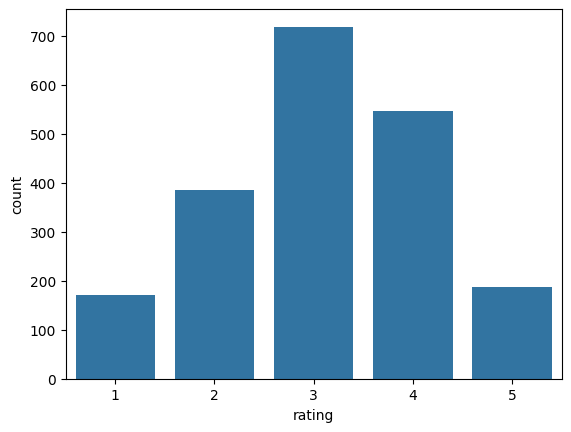

Proporsi rating 5 (dari rating 0-5): 9.32%


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out ratings outside the 0-5 range
df_filtered = df[(df['rating'] >= 1) & (df['rating'] <= 5)]

# distribusi rating
ax = sns.countplot(data=df_filtered, x='rating', order=sorted(df_filtered['rating'].dropna().unique()))
plt.show()

# proporsi rating 5 (from filtered data)
prop_5 = (df_filtered['rating']==5).mean()
print(f"Proporsi rating 5 (dari rating 0-5): {prop_5:.2%}")

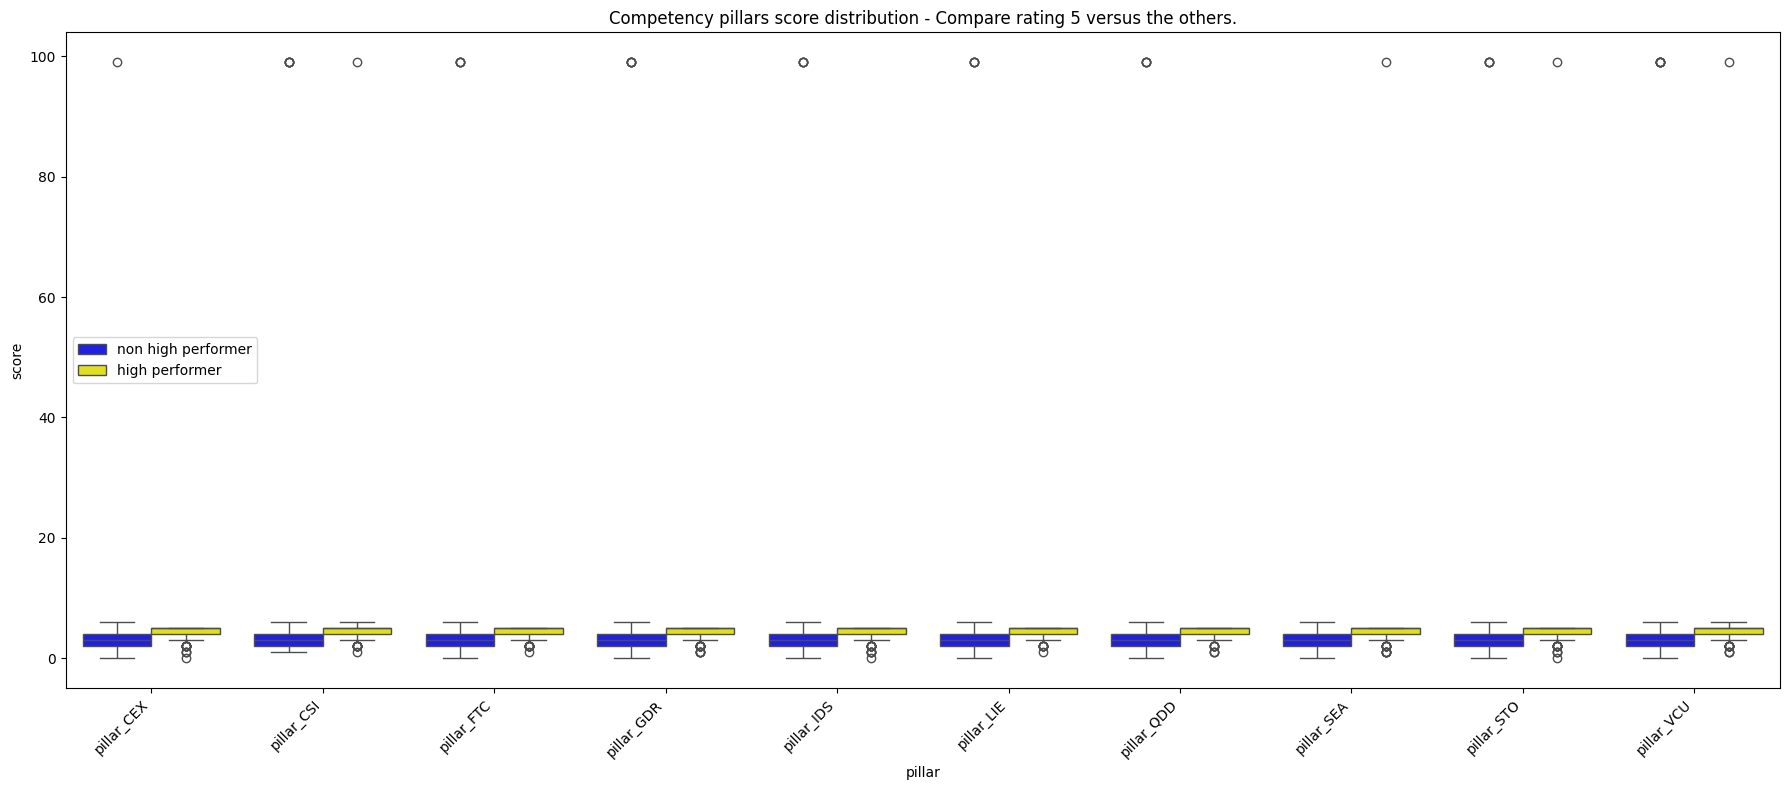

,pillar,median_5,median_other,pval
6,pillar_QDD,5.00000000e+00,3.00000000e+00,8.04674295e-63
7,pillar_SEA,5.00000000e+00,3.00000000e+00,2.96768750e-55
1,pillar_CSI,5.00000000e+00,3.00000000e+00,1.03124002e-54
5,pillar_LIE,5.00000000e+00,3.00000000e+00,1.07853065e-53
9,pillar_VCU,5.00000000e+00,3.00000000e+00,2.86185212e-53
8,pillar_STO,5.00000000e+00,3.00000000e+00,1.37361943e-52
4,pillar_IDS,5.00000000e+00,3.00000000e+00,4.56789682e-51
2,pillar_FTC,5.00000000e+00,3.00000000e+00,4.62186942e-49
0,pillar_CEX,5.00000000e+00,3.00000000e+00,6.90027930e-48
3,pillar_GDR,5.00000000e+00,3.00000000e+00,1.12818373e-46


In [4]:
# ====================================================
# 8. CLEAN FOR ANALYSIS
# ====================================================
df_clean = df[df["rating"].isin([1,2,3,4,5])].copy()


# ====================================================
# 9. BOXPLOT COMPETENCY (BEST RATING)
# ====================================================

# Exclude missing indicator columns
pillar_cols = [c for c in df.columns if c.startswith('pillar_') and not c.endswith('_is_missing')]

# melt untuk plotting
comp_melt = df.melt(id_vars=['employee_id','rating'], value_vars=pillar_cols, var_name='pillar', value_name='score')

# Create custom palette and legend labels
custom_palette = {False: 'blue', True: 'yellow'}
hue_order = [False, True] # Ensure consistent order

# boxplot per pillar, hue rating==5
plt.figure(figsize=(18,8)) # Increased figure size
sns.boxplot(data=comp_melt, x='pillar', y='score', hue=(comp_melt['rating']==5), palette=custom_palette, hue_order=hue_order)
plt.xticks(rotation=45, ha='right') # Rotate labels and align to the right
plt.title("Competency pillars score distribution - Compare rating 5 versus the others.")

# Manually set legend labels after creating the plot
handles, labels = plt.gca().get_legend_handles_labels()
# Map original labels ('False', 'True') to desired labels
new_labels = ['non high performer', 'high performer']
plt.legend(handles, new_labels, title='') # Set empty title

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()


# ====================================================
# 10. MANN-WHITNEY U TEST (BEST RATING)
# ====================================================
from scipy.stats import mannwhitneyu

stat_res = []
for p in pillar_cols:
    group5 = df.loc[df['rating']==5, p].dropna()
    groupother = df.loc[df['rating']!=5, p].dropna()
    if len(group5)>10 and len(groupother)>10:
        stat, pval = mannwhitneyu(group5, groupother, alternative='two-sided')
        stat_res.append((p, group5.median(), groupother.median(), pval))
stat_df = pd.DataFrame(stat_res, columns=['pillar','median_5','median_other','pval']).sort_values('pval')
stat_df

In [5]:
df_clean.to_csv("df_clean.csv", index=False)

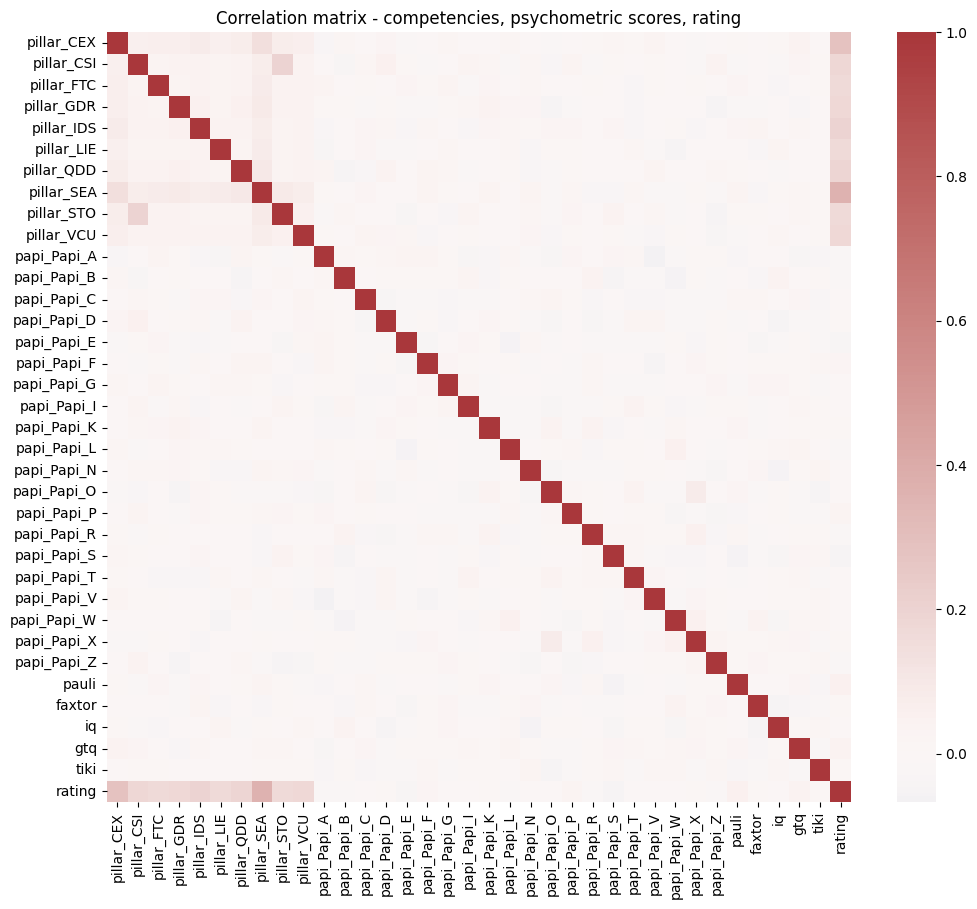

In [6]:
# Define the list of psychometric columns, excluding missing indicators
psych_cols = [c for c in df.columns if (c in ['pauli','faxtor','iq','gtq','tiki'] or c.startswith('papi_')) and not c.endswith('_is_missing')]

corr_cols = pillar_cols + psych_cols + ['rating']
corrmat = df[corr_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corrmat, annot=False, cmap='vlag', center=0)
plt.title("Correlation matrix - competencies, psychometric scores, rating")
plt.show()

===== MODEL PERFORMANCE =====
ROC-AUC    : 0.8958
Precision  : 0.7812
Recall     : 0.6757
F1-score   : 0.7246

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       365
           1       0.78      0.68      0.72        37

    accuracy                           0.95       402
   macro avg       0.87      0.83      0.85       402
weighted avg       0.95      0.95      0.95       402


===== TOP 15 FEATURES (GAIN) =====


,feature,gain
0,num__pillar_QDD,1.58380251e+01
1,num__pillar_SEA,5.12962580e+00
2,num__pillar_STO,4.71069860e+00
3,num__pillar_VCU,4.68433046e+00
4,num__pillar_IDS,4.54617596e+00
5,num__pillar_LIE,3.59442711e+00
6,num__pillar_CSI,3.37304759e+00
7,cat__disc_DI,3.35717177e+00
8,num__papi_Papi_F_is_missing,2.87482405e+00
9,num__pillar_FTC,2.66560793e+00



Generating SHAP Summary Plot...


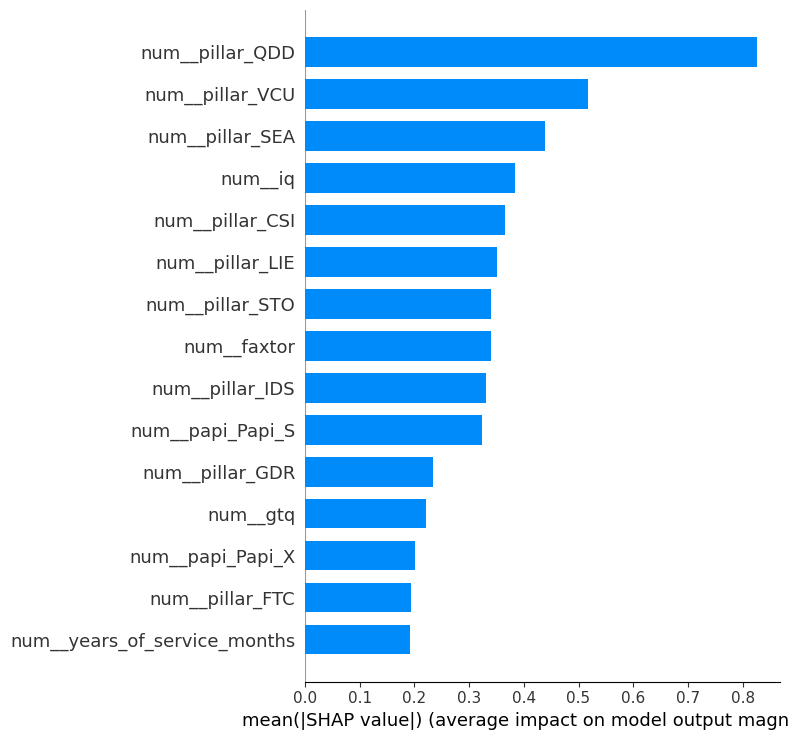


===== SUCCESS FORMULA (TOP 20 WEIGHTS) =====

num__pillar_QDD: 0.1093
num__pillar_SEA: 0.0354
num__pillar_STO: 0.0325
num__pillar_VCU: 0.0323
num__pillar_IDS: 0.0314
num__pillar_LIE: 0.0248
num__pillar_CSI: 0.0233
cat__disc_DI: 0.0232
num__papi_Papi_F_is_missing: 0.0198
num__pillar_FTC: 0.0184
cat__disc_SC: 0.0175
cat__disc_IC: 0.0169
cat__disc_ID: 0.0166
cat__mbti_ISFP: 0.0166
num__pillar_GDR: 0.0163
cat__mbti_ENFP: 0.0161
cat__disc_CD: 0.0161
num__iq_is_missing: 0.0139
cat__disc_word_Dominant-Steadiness: 0.0134
num__papi_Papi_S_is_missing: 0.0127
num__pillar_CEX: 0.0124
num__papi_Papi_C_is_missing: 0.0119
num__strength_Ideation: 0.0112
cat__mbti_nan: 0.0108
cat__disc_CS: 0.0107
num__papi_Papi_V_is_missing: 0.0102
num__papi_Papi_S: 0.0098
cat__disc_CI: 0.0094
cat__disc_SI: 0.0093
cat__disc_word_Dominant-Influencer: 0.0089
num__strength_nan: 0.0088
num__papi_Papi_D: 0.0086
num__gtq: 0.0085
num__papi_Papi_K: 0.0083
num__strength_Belief: 0.0083
num__papi_Papi_O: 0.0083
num__papi_Papi_I:

,feature,weight
0,num__pillar_QDD,1.09326505e-01
1,num__pillar_SEA,3.54087113e-02
2,num__pillar_STO,3.25169464e-02
3,num__pillar_VCU,3.23349327e-02
4,num__pillar_IDS,3.13812817e-02
...,...,...
91,cat__mbti_ENFJ,3.05520133e-03
92,num__strength_Deliberative,2.89701468e-03
93,cat__disc_IS,2.57859140e-03
94,cat__disc_word_Conscientious-Steadiness,1.84775878e-03


In [25]:
# ============================================================
# 1. PREPARATION
# ============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings("ignore")

# Copy df
df_model = df.copy()

# ============================================================
# 2. TARGET: HIGH PERFORMER = 1
# ============================================================
df_model["is_high"] = (df_model["rating"] == 5).astype(int)

# ============================================================
# 3. DROP UNWANTED COLUMNS
# ============================================================
drop_cols = ["rating","employee_id","fullname","year","nik_baru"]
df_model = df_model[[c for c in df_model.columns if c not in drop_cols]]

# ============================================================
# 4. SPLIT FEATURES & TARGET
# ============================================================
X = df_model.drop("is_high", axis=1)
y = df_model["is_high"]

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=object).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder="drop"
)

# ============================================================
# 5. XGBOOST MODEL
# ============================================================
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("xgb", xgb)
])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train
pipeline.fit(X_train, y_train)

# ============================================================
# 6. MODEL PERFORMANCE METRICS
# ============================================================
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

roc  = roc_auc_score(y_test, y_proba)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print("===== MODEL PERFORMANCE =====")
print(f"ROC-AUC    : {roc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1-score   : {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ============================================================
# 7. FEATURE IMPORTANCE (GAIN)
# ============================================================
model = pipeline.named_steps["xgb"]
final_feature_names = pipeline.named_steps["prep"].get_feature_names_out()

importance_gain = model.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame({
    "feature": list(importance_gain.keys()),
    "gain": list(importance_gain.values())
})

importance_df["feature"] = importance_df["feature"].apply(
    lambda x: final_feature_names[int(x[1:])]
)

importance_df.sort_values("gain", ascending=False, inplace=True)
importance_df.reset_index(drop=True, inplace=True)

print("\n===== TOP 15 FEATURES (GAIN) =====")
display(importance_df.head(15))

# ============================================================
# 8. SHAP ANALYSIS (NO ERROR)
# ============================================================
explainer = shap.TreeExplainer(model)

X_transformed = pipeline.named_steps["prep"].transform(X)
shap_values = explainer.shap_values(X_transformed)

X_transformed_df = pd.DataFrame(X_transformed, columns=final_feature_names, index=X.index)

print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_transformed_df, plot_type="bar", max_display=15)

# ============================================================
# 9. BUILD SUCCESS FORMULA (TOP 20)
# ============================================================
importance_df["weight"] = importance_df["gain"] / importance_df["gain"].sum()

top_formula = importance_df.head(103).copy()

print("\n===== SUCCESS FORMULA (TOP 20 WEIGHTS) =====\n")
for i, row in top_formula.iterrows():
    print(f"{row['feature']}: {row['weight']:.4f}")

success_formula_df = top_formula[["feature", "weight"]]
display(success_formula_df)


In [29]:
# ------------------------------------------------------------
# STEP-2 Python Implementation: TV -> TGV -> Final Match Rate
# Requirements: df (merged employee features), optional:
#              importance_df (feature, gain, weight), importance_strength (feature, weight)
# Output: df_match (employee_id, tgv matches, final_match_rate)
# ------------------------------------------------------------

import pandas as pd
import numpy as np
from collections import defaultdict

# ---------------------------
# CONFIG / PARAMETERS
# ---------------------------

# If you want to supply custom benchmark employees (list of employee_id), set it here.
# If None, default = all employees with rating == 5
selected_benchmark_ids = None  # e.g. ["EMP1001","EMP1012"] or None for rating==5

# If you want to force certain TVs to be 'lower_is_better' (e.g. error counts), list them:
lower_is_better_tvs = []  # e.g. ["pauli"] if lower is better; otherwise leave empty

# Optional: provide tgv_weights (must sum to 1). If None, script will derive them.
# Example: {"competency":0.5, "psychometric":0.3, "cognitive":0.1, "strength":0.1}
tgv_weights = None

# TV internal weights: if you have importance_df & importance_strength variables in env, script will use them.
# Otherwise TV weights within each TGV will be equal.
# ---------------------------


# ---------------------------
# 0. Helper utilities
# ---------------------------
def is_categorical_series(s: pd.Series):
    # treat non-numeric as categorical or one-hot 0/1 (but 0/1 numeric is treated as numeric)
    if pd.api.types.is_numeric_dtype(s):
        # treat as categorical if only 0/1 distinct values and original name seems boolean-like
        uniq = set(s.dropna().unique())
        if uniq.issubset({0,1}):
            return True
        return False
    else:
        return True

def safe_median(series: pd.Series):
    s = pd.to_numeric(series, errors="coerce").dropna()
    return float(s.median()) if len(s)>0 else np.nan

def safe_mode(series: pd.Series):
    vals = series.dropna().astype(str)
    if len(vals)==0:
        return np.nan
    return vals.mode().iloc[0]

def compute_tv_match_numeric(emp_series, baseline, lower_is_better=False):
    # emp_series: pd.Series (employee values)
    # baseline: scalar
    # returns Series with values in [0,1]
    s = pd.to_numeric(emp_series, errors="coerce")
    # if baseline missing or 0 -> return zeros
    if pd.isna(baseline) or baseline == 0:
        return pd.Series(0.0, index=s.index)
    if not lower_is_better:
        out = (s / baseline).clip(upper=1.0).fillna(0.0)
    else:
        # inverted direction per spec: ((2*b - x)/b), then clip 0..1
        out = ((2*baseline - s) / baseline).clip(lower=0.0, upper=1.0).fillna(0.0)
    return out

def compute_tv_match_categorical(emp_series, baseline_mode):
    # exact match -> 1 else 0. baseline_mode is string representation
    out = emp_series.fillna("").astype(str).str.strip().str.upper() == str(baseline_mode).strip().upper()
    return out.astype(float).fillna(0.0)

# ---------------------------
# 1. Prepare benchmark set
# ---------------------------
df_features = df.copy()  # use user's merged dataframe

if selected_benchmark_ids is None:
    benchmark_df = df_features[df_features['rating'] == 5].copy()
else:
    benchmark_df = df_features[df_features['employee_id'].isin(selected_benchmark_ids)].copy()

if benchmark_df.shape[0] == 0:
    raise ValueError("No benchmark employees found. Ensure selected_benchmark_ids or rating==5 exist in df.")

print(f"Using {len(benchmark_df)} benchmark employees for baseline calculation.")

# ---------------------------
# 2. Define TV -> TGV mapping (auto-detect + editable)
# We'll map by column name patterns; adjust lists if needed.
# ---------------------------

cols = df_features.columns.tolist()

# Competency: columns starting with 'pillar_'
competency_tvs = [c for c in cols if c.startswith("pillar_")]

# Psychometric: papi_*, disc, mbti, any others explicit
papi_tvs = [c for c in cols if c.startswith("papi_")]
disc_cols = [c for c in cols if c.lower().startswith("disc")]
mbti_cols = [c for c in cols if c.lower().startswith("mbti")]
psychometric_tvs = papi_tvs + disc_cols + mbti_cols

# Cognitive: common cognitive columns
cognitive_candidates = ["iq","gtq","tiki","pauli","faxtor","gtq_total","tiki_total"]
cognitive_tvs = [c for c in cols if c.lower() in cognitive_candidates]

# Strength: columns starting with 'strength_'
strength_tvs = [c for c in cols if c.startswith("strength_")]

# You can modify mapping manually here if needed:
TGV_TO_TVS = {
    "competency": competency_tvs,
    "psychometric": psychometric_tvs,
    "cognitive": cognitive_tvs,
    "strength": strength_tvs
}

# drop empty groups
TGV_TO_TVS = {k: v for k,v in TGV_TO_TVS.items() if len(v)>0}

print("TGV -> #TVs mapping (auto-detected):")
for k,v in TGV_TO_TVS.items():
    print(f" - {k}: {len(v)} TVs")

# ---------------------------
# 3. Compute baselines (median for numeric TVs; mode for categorical TVs)
# ---------------------------

baseline_map = {}   # tv -> baseline scalar or category
tv_is_numeric = {}

for tgv, tvs in TGV_TO_TVS.items():
    for tv in tvs:
        series_bench = benchmark_df.get(tv, pd.Series([], dtype=object))
        # decide numeric vs categorical using df_features overall
        series_full = df_features.get(tv, pd.Series([], dtype=object))
        is_num = pd.api.types.is_numeric_dtype(series_full) and not set(series_full.dropna().unique()).issubset({0,1})
        tv_is_numeric[tv] = is_num
        if is_num:
            baseline = safe_median(series_bench)
            baseline_map[tv] = baseline
        else:
            baseline_map[tv] = safe_mode(series_bench)

# quick inspect few baselines
print("\nExample baselines (first 10 TVs):")
for i, (tv, b) in enumerate(list(baseline_map.items())[:10]):
    print(f" - {tv}: {b}")

# ---------------------------
# 4. Derive TV internal weights (per TGV)
#    Prefer using importance_df and importance_strength if available.
# ---------------------------

# Try to read importance_df and importance_strength from current env (not passed to function)
tv_weights_within_tgv = {}  # tgv -> {tv: weight_in_tgv}

# helper to extract weight from importance_df (which may contain OHE feature names)
def lookup_importance_for_tv(tv_name, importance_df):
    # importance_df expected to have 'feature' and 'weight' columns
    # try exact match, contains, or endswith
    if 'feature' not in importance_df.columns:
        return None
    # exact
    row = importance_df[importance_df['feature'].str.lower() == tv_name.lower()]
    if len(row)>0:
        return float(row['weight'].iloc[0])
    # contains
    row = importance_df[importance_df['feature'].str.lower().str.contains(tv_name.lower())]
    if len(row)>0:
        return float(row['weight'].iloc[0])
    return None

# attempt to use global importance_df & importance_strength
try:
    imp_df = importance_df.copy()
    imp_strength = importance_strength.copy()
except Exception:
    imp_df = None
    imp_strength = None

for tgv, tvs in TGV_TO_TVS.items():
    weight_map = {}
    if tgv == "strength" and imp_strength is not None:
        # importance_strength uses 'feature' names like 'strength_Achiever'
        for tv in tvs:
            # tv likely 'strength_Achiever' exact match
            w = lookup_importance_for_tv(tv, imp_strength) if imp_strength is not None else None
            weight_map[tv] = float(w) if w is not None else np.nan
    else:
        # search in global importance_df
        for tv in tvs:
            w = lookup_importance_for_tv(tv, imp_df) if imp_df is not None else None
            weight_map[tv] = float(w) if w is not None else np.nan
    # if all nan -> fallback equal weights
    if all(np.isnan(list(weight_map.values()))):
        equal = 1.0 / max(1, len(tvs))
        weight_map = {tv: equal for tv in tvs}
    else:
        # fill nan with small epsilon then normalize
        tmp = {tv: (0.0 if (np.isnan(w) if isinstance(w, float) else w is None) else w) for tv,w in weight_map.items()}
        s = sum(tmp.values())
        if s == 0:
            # fallback equal
            equal = 1.0 / max(1, len(tvs))
            tmp = {tv: equal for tv in tvs}
        else:
            tmp = {tv: val/s for tv,val in tmp.items()}
        weight_map = tmp
    tv_weights_within_tgv[tgv] = weight_map

print("\nExample TV weights within TGV (sample):")
for tgv, m in tv_weights_within_tgv.items():
    print(f" - {tgv}: {len(m)} TVs, sample: {list(m.items())[:5]}")

# ---------------------------
# 5. Derive / set TGV-level weights
#    If tgv_weights provided, use them. Otherwise try to derive from sum of importance values,
#    else fallback to equal weights.
# ---------------------------

if tgv_weights is None:
    # try derive using sum of original importance across TVs
    derived = {}
    total = 0.0
    for tgv, tvs in TGV_TO_TVS.items():
        s = 0.0
        for tv in tvs:
            # get weight within_tgv before normalization *use gain proxy if available*
            # prefer lookup in imp_df
            val = None
            if imp_df is not None:
                val = lookup_importance_for_tv(tv, imp_df)
            if val is None and imp_strength is not None:
                val = lookup_importance_for_tv(tv, imp_strength)
            s += (val if val is not None else 0.0)
        derived[tgv] = s
        total += s
    if total > 0:
        tgv_weights = {tgv: derived[tgv]/total for tgv in derived.keys()}
    else:
        # fallback equal
        n = len(TGV_TO_TVS)
        tgv_weights = {tgv: 1.0/n for tgv in TGV_TO_TVS.keys()}

print("\nTGV weights used:")
for k,v in tgv_weights.items():
    print(f" - {k}: {v:.3f}")

# ---------------------------
# 6. Compute TV match rates for each employee
# ---------------------------

tv_match_df = pd.DataFrame(index=df_features.index)
tv_match_df['employee_id'] = df_features['employee_id']

for tgv, tvs in TGV_TO_TVS.items():
    for tv in tvs:
        if tv_is_numeric.get(tv, False):
            series_emp = df_features.get(tv, pd.Series(np.nan, index=df_features.index))
            baseline = baseline_map.get(tv, np.nan)
            tv_match_df[tv] = compute_tv_match_numeric(series_emp, baseline, lower_is_better=(tv in lower_is_better_tvs))
        else:
            series_emp = df_features.get(tv, pd.Series("", index=df_features.index))
            baseline_mode = baseline_map.get(tv, "")
            tv_match_df[tv] = compute_tv_match_categorical(series_emp, baseline_mode)

# ---------------------------
# 7. Aggregate per TGV using internal tv weights
# ---------------------------
tgv_match_cols = {}
for tgv, tvs in TGV_TO_TVS.items():
    weights_map = tv_weights_within_tgv[tgv]
    # ensure tvs exist in tv_match_df
    valid_tvs = [tv for tv in tvs if tv in tv_match_df.columns]
    if len(valid_tvs) == 0:
        tgv_match_cols[tgv] = pd.Series(0.0, index=df_features.index)
        continue
    # weighted sum; if some tv missing per-employee treat as 0 contribution
    weighted = pd.Series(0.0, index=df_features.index)
    denom = 0.0
    for tv in valid_tvs:
        w = weights_map.get(tv, 0)
        weighted += tv_match_df[tv].fillna(0.0) * w
        denom += w
    if denom == 0:
        tgv_match = weighted
    else:
        tgv_match = weighted / denom
    tgv_match_cols[tgv] = tgv_match

# attach to result
df_match = df_features[['employee_id','fullname','rating']].copy()
for tgv, series in tgv_match_cols.items():
    df_match[f"{tgv}_match"] = series

# ---------------------------
# 8. Compute final match rate (weighted across TGV)
# ---------------------------
final = pd.Series(0.0, index=df_match.index)
for tgv, w in tgv_weights.items():
    if f"{tgv}_match" in df_match.columns:
        final += df_match[f"{tgv}_match"] * w

# optional: normalize by sum of tgv_weights present
present_sum = sum([w for tgv,w in tgv_weights.items() if f"{tgv}_match" in df_match.columns])
if present_sum != 0:
    final = final / present_sum

df_match['final_match_rate'] = final.clip(0,1)
df_match['final_match_pct'] = df_match['final_match_rate'] * 100.0

# ---------------------------
# 9. Output / save
# ---------------------------

print("\nSample output (top 10 by final_match_rate):")
display(df_match.sort_values("final_match_rate", ascending=False).head(10))

# save
df_match.to_csv("df_match_rates.csv", index=False)
print("\nSaved df_match_rates.csv (employee_id, tgv matches, final_match_rate)")

# ---------------------------
# 10. Optional diagnostics: show benchmark distribution and few TV examples
# ---------------------------
print("\nBenchmark summary (sample TVs):")
sample_tvs = []
for k,v in TGV_TO_TVS.items():
    sample_tvs += v[:2]
sample_tvs = sample_tvs[:8]
for tv in sample_tvs:
    print(f" - {tv}: baseline = {baseline_map.get(tv)}")

# show tv_weights_within_tgv size summary
print("\nTV counts & sample weights per TGV:")
for tgv, m in tv_weights_within_tgv.items():
    nonzero = [tv for tv,w in m.items() if w>0]
    print(f" - {tgv}: {len(m)} TVs, nonzero sample: {list(m.items())[:5]}")


Using 187 benchmark employees for baseline calculation.
TGV -> #TVs mapping (auto-detected):
 - competency: 20 TVs
 - psychometric: 43 TVs
 - cognitive: 5 TVs
 - strength: 20 TVs

Example baselines (first 10 TVs):
 - pillar_CEX: 5.0
 - pillar_CSI: 5.0
 - pillar_FTC: 5.0
 - pillar_GDR: 5.0
 - pillar_IDS: 5.0
 - pillar_LIE: 5.0
 - pillar_QDD: 5.0
 - pillar_SEA: 5.0
 - pillar_STO: 5.0
 - pillar_VCU: 5.0

Example TV weights within TGV (sample):
 - competency: 20 TVs, sample: [('pillar_CEX', 0.036816400459132745), ('pillar_CSI', 0.06926725964315074), ('pillar_FTC', 0.05473962391583054), ('pillar_GDR', 0.048492081104429076), ('pillar_IDS', 0.09335805142142067)]
 - psychometric: 43 TVs, sample: [('papi_Papi_A', 0.027687363164312067), ('papi_Papi_B', 0.02354402294964039), ('papi_Papi_C', 0.043235648489598225), ('papi_Papi_D', 0.03124140503271025), ('papi_Papi_E', 0.022184779830193974)]
 - cognitive: 5 TVs, sample: [('pauli', 0.1576385556618133), ('faxtor', 0.17985615279876954), ('iq', 0.325807

,employee_id,fullname,rating,competency_match,psychometric_match,cognitive_match,strength_match,final_match_rate,final_match_pct
1252,EMP101242,Sari Saputra Tamba,4,8.58482637e-01,9.00400049e-01,9.10647303e-01,8.00520451e-01,8.67343553e-01,8.67343553e+01
934,EMP100924,Julia Yudhistira Lukman,5,9.64266693e-01,7.80855218e-01,9.78882830e-01,7.44683226e-01,8.65895099e-01,8.65895099e+01
848,EMP100838,Nurlita Permadi,5,9.86146548e-01,7.14674675e-01,1.00000000e+00,7.94744405e-01,8.60734990e-01,8.60734990e+01
1665,EMP101655,Dimas Zulfikar,4,9.82938304e-01,7.70678931e-01,6.09983212e-01,7.48700586e-01,8.50599557e-01,8.50599557e+01
1812,EMP101802,Tania Wijaya Lukman,5,9.78932101e-01,7.62512619e-01,8.54274110e-01,6.48484064e-01,8.43996650e-01,8.43996650e+01
472,EMP100462,Lestari Anggara,5,1.00000000e+00,7.68997840e-01,8.28190197e-01,5.51498816e-01,8.39045390e-01,8.39045390e+01
1728,EMP101718,Intan Kurniawan,5,9.64590979e-01,7.34416202e-01,7.71896713e-01,7.42790124e-01,8.37764409e-01,8.37764409e+01
1360,EMP101350,Bella Dharma Maulida,5,9.70954262e-01,7.60843154e-01,7.62216583e-01,6.58938651e-01,8.36458871e-01,8.36458871e+01
1601,EMP101591,Andi Situmorang,5,9.28569879e-01,7.68232406e-01,9.23158300e-01,7.01389181e-01,8.36131772e-01,8.36131772e+01
218,EMP100208,Hadi Tri Maulida,3,9.89052075e-01,7.50828598e-01,8.14263933e-01,6.05833601e-01,8.35437775e-01,8.35437775e+01



Saved df_match_rates.csv (employee_id, tgv matches, final_match_rate)

Benchmark summary (sample TVs):
 - pillar_CEX: baseline = 5.0
 - pillar_CSI: baseline = 5.0
 - papi_Papi_A: baseline = 5.0
 - papi_Papi_B: baseline = 5.0
 - pauli: baseline = 63.0
 - faxtor: baseline = 60.0
 - strength_Achiever: baseline = 0
 - strength_Activator: baseline = 0

TV counts & sample weights per TGV:
 - competency: 20 TVs, nonzero sample: [('pillar_CEX', 0.036816400459132745), ('pillar_CSI', 0.06926725964315074), ('pillar_FTC', 0.05473962391583054), ('pillar_GDR', 0.048492081104429076), ('pillar_IDS', 0.09335805142142067)]
 - psychometric: 43 TVs, nonzero sample: [('papi_Papi_A', 0.027687363164312067), ('papi_Papi_B', 0.02354402294964039), ('papi_Papi_C', 0.043235648489598225), ('papi_Papi_D', 0.03124140503271025), ('papi_Papi_E', 0.022184779830193974)]
 - cognitive: 5 TVs, nonzero sample: [('pauli', 0.1576385556618133), ('faxtor', 0.17985615279876954), ('iq', 0.325807771029556), ('gtq', 0.198027316220

# **Data Story**: Discover the Pattern of Success
This project was conducted to uncover the factors that truly differentiate high-performing employees—specifically those who achieved a performance rating of 5. By examining multiple dimensions of employee data, including competencies, psychometrics, strengths, and demographic attributes, the goal was to identify the core elements associated with top performance and translate them into a practical Success Formula that organizations can use for talent decisions.


1. Starting the Journey: Understanding the Data Landscape

The first step of the analysis involved breaking down the components of employee data individually to identify any early signals of what makes a high performer.

Competency Pillars — The First Strong Signal

The competency analysis immediately revealed a clear pattern:
Employees with a performance rating of 5 consistently scored higher across nearly all competency pillars, with statistical tests confirming that these differences were significant.

This finding established competencies as the strongest early indicator of top performance.

2. Exploring Psychometric Profiles

Next, I examined various psychometric assessments such as Pauli, GTQ, IQ, and others. Unlike the competency data, these variables did not show strong, consistent distinctions across performance levels when analyzed individually.

Even though psychometrics did not emerge as clear standalone predictors at this stage, I kept them as part of the broader context—as they might add value when combined with other variables.

3. Behavioral Strengths — Subtle but Meaningful Patterns

The analysis of strengths showed that certain behavioral themes appeared more frequently among employees rated 5.
This suggested that beyond skill and capability, specific behavioral tendencies may help create conditions that support high performance.

These strengths served as additional clues in defining the “behavioral fingerprint” of top performers.

4. Demographic Factors — Supporting, Not Leading

I also explored demographic variables such as grade, tenure, and education level. These factors showed minor associations with high performance, but not strong enough to be considered primary drivers.

They function more as contextual contributors rather than key differentiators.

5. Going Beyond Individual Insights: Predictive Modeling

To understand how all these factors work together, I built a predictive model to estimate the likelihood of an employee receiving a rating of 5.

The model performed well, indicating that the dataset contained meaningful signals.

Feature Importance: Identifying the Core DNA

The most insightful output from the predictive modeling phase was the feature importance analysis.
This allowed me to pinpoint the exact variables the model relied on most when predicting high performance.

It moved the analysis from “What correlates?” to:

👉 “What truly drives high performance when everything is considered together?”

6. Constructing the Success Formula

Using the most influential features from the model, I created a weighted Success Score that represents a simplified formula of what contributes most to a rating of 5.
| Feature                            | Weight     |
| ---------------------------------- | ---------- |
| **num__pillar_QDD**                | **0.1093** |
| num__pillar_SEA                    | 0.0354     |
| num__pillar_STO                    | 0.0325     |
| num__pillar_VCU                    | 0.0323     |
| num__pillar_IDS                    | 0.0314     |
| num__pillar_LIE                    | 0.0248     |
| num__pillar_CSI                    | 0.0233     |
| cat__disc_DI                       | 0.0232     |
| num__papi_Papi_F_is_missing        | 0.0198     |
| num__pillar_FTC                    | 0.0184     |
| cat__disc_SC                       | 0.0175     |
| cat__disc_IC                       | 0.0169     |
| cat__disc_ID                       | 0.0166     |
| cat__mbti_ISFP                     | 0.0166     |
| num__pillar_GDR                    | 0.0163     |
| cat__mbti_ENFP                     | 0.0161     |
| cat__disc_CD                       | 0.0161     |
| num__iq_is_missing                 | 0.0139     |
| cat__disc_word_Dominant-Steadiness | 0.0134     |
| num__papi_Papi_S_is_missing        | 0.0127     |


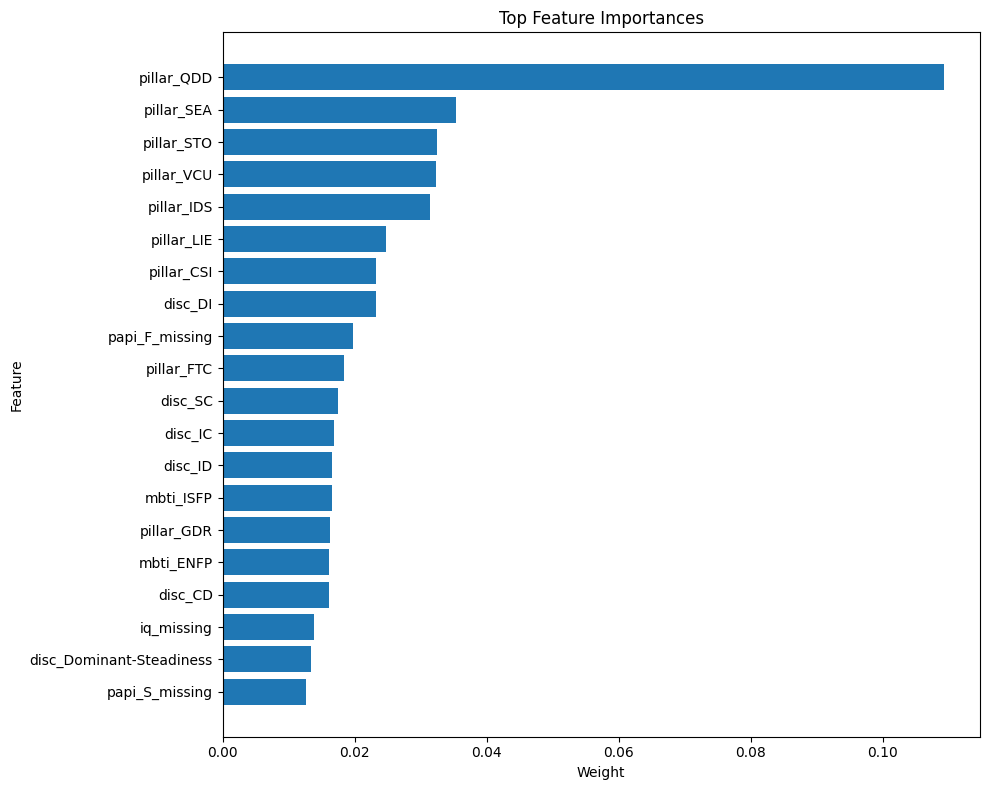

In [38]:
# Data
features = [
    "pillar_QDD", "pillar_SEA", "pillar_STO", "pillar_VCU", "pillar_IDS",
    "pillar_LIE", "pillar_CSI", "disc_DI", "papi_F_missing", "pillar_FTC",
    "disc_SC", "disc_IC", "disc_ID", "mbti_ISFP", "pillar_GDR",
    "mbti_ENFP", "disc_CD", "iq_missing", "disc_Dominant-Steadiness",
    "papi_S_missing"
]

weights = [
    0.1093, 0.0354, 0.0325, 0.0323, 0.0314,
    0.0248, 0.0233, 0.0232, 0.0198, 0.0184,
    0.0175, 0.0169, 0.0166, 0.0166, 0.0163,
    0.0161, 0.0161, 0.0139, 0.0134,
    0.0127
]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(features, weights)
plt.xlabel("Weight")
plt.ylabel("Feature")
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()